In [1]:
import sys
import os

# Add Codes/src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

In [2]:
import pandas as pd
import numpy as np
import torch
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from train_utils import BatteryTrainerBase

/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
df = pd.read_pickle('../../../Datasets/processed/merged_interp_flat.pkl')
df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,dqdt_min,dqdt_max,dqdt_mean,dqdt_std,dvdt_min,...,i_interp_991,i_interp_992,i_interp_993,i_interp_994,i_interp_995,i_interp_996,i_interp_997,i_interp_998,i_interp_999,source
0,B0005,2.0,1,1.856487,0.928244,-1.332504e-07,0.002876,0.000528,0.000255,-0.006229,...,0.004819,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,nasa
1,B0005,2.0,3,1.846327,0.923164,-4.510385e-07,0.002894,0.000527,0.000257,-0.006004,...,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,nasa
2,B0005,2.0,5,1.835349,0.917675,-1.163391e-07,0.002333,0.000520,0.000227,-0.005953,...,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,nasa
3,B0005,2.0,7,1.835263,0.917631,-2.062661e-07,0.002885,0.000530,0.000255,-0.005907,...,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,nasa
4,B0005,2.0,9,1.834646,0.917323,-5.353266e-07,0.002896,0.000530,0.000256,-0.005923,...,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,nasa


In [5]:
class BatteryTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, **model_kwargs):
        ###
        # UBAH DISINI SESUAI MODEL MASING MASING
        ###
        # n_estimators=100, learning_rate=0.1, max_depth=6
        X_train = train_df[feature_cols].values
        y_train = train_df[self.target_cols].values
        X_val = val_df[feature_cols].values
        y_val = val_df[self.target_cols].values

        model = XGBRegressor(
            n_estimators=model_kwargs.get("n_estimators", 100),
            learning_rate=model_kwargs.get("learning_rate", 0.1),
            max_depth=model_kwargs.get("max_depth", 6),
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        print(f"XGBoost Val MSE={mean_squared_error(y_val, y_pred):.4f}, MAE={mean_absolute_error(y_val, y_pred):.4f}, R²={r2_score(y_val, y_pred):.4f}")

        return model, y_val, y_pred
    
    def optuna_objective(self, trial):
        ###
        # UBAH DISINI SESUAI MODEL MASING MASING
        ###
        n_estimators = trial.suggest_categorical("n_estimators", [100, 300])
        learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.1])
        max_depth = trial.suggest_categorical("max_depth", [3, 6])

        result = self.cross_validate(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
        )

        # for robust
        std_mse = np.std(result.mse)
        score = result.avg_mse + 0.8 * std_mse # we can tune the weight

        return score

In [6]:
trainer = BatteryTrainer(df, target_cols=['soh'])

In [7]:
result = trainer.cross_validate()


=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0012, MAE=0.0158, R²=0.9786
  MSE: 0.0012, MAE: 0.0158, R²: 0.9786

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0017, MAE=0.0206, R²=0.9517
  MSE: 0.0017, MAE: 0.0206, R²: 0.9517

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0010, MAE=0.0135, R²=0.9775
  MSE: 0.0010, MAE: 0.0135, R²: 0.9775

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0184, R²=0.9329
  MSE: 0.0025, MAE: 0.0184, R²: 0.9329

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0011, MAE=0.0113, R²=0.9848
  MSE: 0.0011, MAE: 0.0113, R²: 0.

In [8]:
study = trainer.run_optuna_tuning()

[I 2025-04-17 09:56:16,281] A new study created in memory with name: no-name-8979a39e-ca8d-4b28-89ef-f8bca7ee78db



=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0034, MAE=0.0373, R²=0.9408
  MSE: 0.0034, MAE: 0.0373, R²: 0.9408

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0365, R²=0.9270
  MSE: 0.0025, MAE: 0.0365, R²: 0.9270

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0031, MAE=0.0379, R²=0.9318
  MSE: 0.0031, MAE: 0.0379, R²: 0.9318

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0033, MAE=0.0386, R²=0.9111
  MSE: 0.0033, MAE: 0.0386, R²: 0.9111

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


[I 2025-04-17 09:56:52,537] Trial 0 finished with value: 0.0032841960109268905 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 3}. Best is trial 0 with value: 0.0032841960109268905.


XGBoost Val MSE=0.0026, MAE=0.0306, R²=0.9644
  MSE: 0.0026, MAE: 0.0306, R²: 0.9644

=== Average CV Performance ===
Avg MSE: 0.0030
Avg MAE: 0.0362
Avg R² : 0.9350

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0013, MAE=0.0157, R²=0.9778
  MSE: 0.0013, MAE: 0.0157, R²: 0.9778

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0016, MAE=0.0197, R²=0.9527
  MSE: 0.0016, MAE: 0.0197, R²: 0.9527

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0010, MAE=0.0128, R²=0.9782
  MSE: 0.0010, MAE: 0.0128, R²: 0.9782

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0177, R²=0.9341
  MSE: 0.0025, MAE: 0.0177, R²: 0.9341

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 09:58:31,986] Trial 1 finished with value: 0.0019158725132099328 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0011, MAE=0.0110, R²=0.9849
  MSE: 0.0011, MAE: 0.0110, R²: 0.9849

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0153
Avg R² : 0.9656

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0012, MAE=0.0158, R²=0.9786
  MSE: 0.0012, MAE: 0.0158, R²: 0.9786

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0017, MAE=0.0206, R²=0.9517
  MSE: 0.0017, MAE: 0.0206, R²: 0.9517

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0010, MAE=0.0135, R²=0.9775
  MSE: 0.0010, MAE: 0.0135, R²: 0.9775

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0184, R²=0.9329
  MSE: 0.0025, MAE: 0.0184, R²: 0.9329

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 09:59:11,769] Trial 2 finished with value: 0.0019445970711626669 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0011, MAE=0.0113, R²=0.9848
  MSE: 0.0011, MAE: 0.0113, R²: 0.9848

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0159
Avg R² : 0.9651

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0090, MAE=0.0709, R²=0.8433
  MSE: 0.0090, MAE: 0.0709, R²: 0.8433

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0060, MAE=0.0594, R²=0.8255
  MSE: 0.0060, MAE: 0.0594, R²: 0.8255

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0079, MAE=0.0660, R²=0.8278
  MSE: 0.0079, MAE: 0.0660, R²: 0.8278

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0097, MAE=0.0716, R²=0.7422
  MSE: 0.0097, MAE: 0.0716, R²: 0.7422

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 09:59:55,442] Trial 3 finished with value: 0.010557031572603865 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0122, MAE=0.0762, R²=0.8310
  MSE: 0.0122, MAE: 0.0762, R²: 0.8310

=== Average CV Performance ===
Avg MSE: 0.0089
Avg MAE: 0.0688
Avg R² : 0.8140

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0239, R²=0.9559
  MSE: 0.0025, MAE: 0.0239, R²: 0.9559

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0013, MAE=0.0219, R²=0.9628
  MSE: 0.0013, MAE: 0.0219, R²: 0.9628

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0008, MAE=0.0163, R²=0.9823
  MSE: 0.0008, MAE: 0.0163, R²: 0.9823

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0017, MAE=0.0212, R²=0.9551
  MSE: 0.0017, MAE: 0.0212, R²: 0.9551

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 10:00:31,441] Trial 4 finished with value: 0.001957422016943744 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 3}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0011, MAE=0.0141, R²=0.9841
  MSE: 0.0011, MAE: 0.0141, R²: 0.9841

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0195
Avg R² : 0.9680

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0022, MAE=0.0249, R²=0.9607
  MSE: 0.0022, MAE: 0.0249, R²: 0.9607

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0015, MAE=0.0256, R²=0.9570
  MSE: 0.0015, MAE: 0.0256, R²: 0.9570

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0014, MAE=0.0222, R²=0.9703
  MSE: 0.0014, MAE: 0.0222, R²: 0.9703

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0020, MAE=0.0259, R²=0.9466
  MSE: 0.0020, MAE: 0.0259, R²: 0.9466

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 10:00:47,630] Trial 5 finished with value: 0.001987141693615217 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0014, MAE=0.0175, R²=0.9802
  MSE: 0.0014, MAE: 0.0175, R²: 0.9802

=== Average CV Performance ===
Avg MSE: 0.0017
Avg MAE: 0.0232
Avg R² : 0.9629

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0090, MAE=0.0709, R²=0.8433
  MSE: 0.0090, MAE: 0.0709, R²: 0.8433

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0060, MAE=0.0594, R²=0.8255
  MSE: 0.0060, MAE: 0.0594, R²: 0.8255

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0079, MAE=0.0660, R²=0.8278
  MSE: 0.0079, MAE: 0.0660, R²: 0.8278

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0097, MAE=0.0716, R²=0.7422
  MSE: 0.0097, MAE: 0.0716, R²: 0.7422

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 10:01:31,727] Trial 6 finished with value: 0.010557031572603865 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0122, MAE=0.0762, R²=0.8310
  MSE: 0.0122, MAE: 0.0762, R²: 0.8310

=== Average CV Performance ===
Avg MSE: 0.0089
Avg MAE: 0.0688
Avg R² : 0.8140

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0013, MAE=0.0157, R²=0.9778
  MSE: 0.0013, MAE: 0.0157, R²: 0.9778

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0016, MAE=0.0197, R²=0.9527
  MSE: 0.0016, MAE: 0.0197, R²: 0.9527

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0010, MAE=0.0128, R²=0.9782
  MSE: 0.0010, MAE: 0.0128, R²: 0.9782

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0177, R²=0.9341
  MSE: 0.0025, MAE: 0.0177, R²: 0.9341

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 10:03:16,206] Trial 7 finished with value: 0.0019158725132099328 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0011, MAE=0.0110, R²=0.9849
  MSE: 0.0011, MAE: 0.0110, R²: 0.9849

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0153
Avg R² : 0.9656

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0135, MAE=0.0893, R²=0.7641
  MSE: 0.0135, MAE: 0.0893, R²: 0.7641

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0091, MAE=0.0772, R²=0.7330
  MSE: 0.0091, MAE: 0.0772, R²: 0.7330

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0117, MAE=0.0834, R²=0.7437
  MSE: 0.0117, MAE: 0.0834, R²: 0.7437

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0116, MAE=0.0851, R²=0.6894
  MSE: 0.0116, MAE: 0.0851, R²: 0.6894

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 10:03:33,110] Trial 8 finished with value: 0.014194817800550012 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0159, MAE=0.0872, R²=0.7783
  MSE: 0.0159, MAE: 0.0872, R²: 0.7783

=== Average CV Performance ===
Avg MSE: 0.0124
Avg MAE: 0.0844
Avg R² : 0.7417

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0013, MAE=0.0157, R²=0.9778
  MSE: 0.0013, MAE: 0.0157, R²: 0.9778

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0016, MAE=0.0197, R²=0.9527
  MSE: 0.0016, MAE: 0.0197, R²: 0.9527

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0010, MAE=0.0128, R²=0.9782
  MSE: 0.0010, MAE: 0.0128, R²: 0.9782

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0177, R²=0.9341
  MSE: 0.0025, MAE: 0.0177, R²: 0.9341

=== Fold 5 ===
[nasa] Normaliz

[I 2025-04-17 10:05:17,565] Trial 9 finished with value: 0.0019158725132099328 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 1 with value: 0.0019158725132099328.


XGBoost Val MSE=0.0011, MAE=0.0110, R²=0.9849
  MSE: 0.0011, MAE: 0.0110, R²: 0.9849

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0153
Avg R² : 0.9656

Best trial:
  MSE: 0.0019
  Params:
    n_estimators: 300
    learning_rate: 0.1
    max_depth: 6


In [9]:
base_model = trainer.train_base_model()


Training base model with default hyperparameters
XGBoost Val MSE=0.0021, MAE=0.0200, R²=0.9634


In [10]:
tuned_model = trainer.train_tuned_model()


Training with best Optuna params:
  n_estimators: 300
  learning_rate: 0.1
  max_depth: 6
XGBoost Val MSE=0.0021, MAE=0.0196, R²=0.9636



Running cross-validation for base model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0012, MAE=0.0158, R²=0.9786
  MSE: 0.0012, MAE: 0.0158, R²: 0.9786

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0017, MAE=0.0206, R²=0.9517
  MSE: 0.0017, MAE: 0.0206, R²: 0.9517

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0010, MAE=0.0135, R²=0.9775
  MSE: 0.0010, MAE: 0.0135, R²: 0.9775

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0025, MAE=0.0184, R²=0.9329
  MSE: 0.0025, MAE: 0.0184, R²: 0.9329

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
XGBoost Val MSE=0.0011, MAE=0.0113, 

/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/Users/rizqipm/Documents/USYD_MDS/DATA5703_code/CS64-Capstone/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect

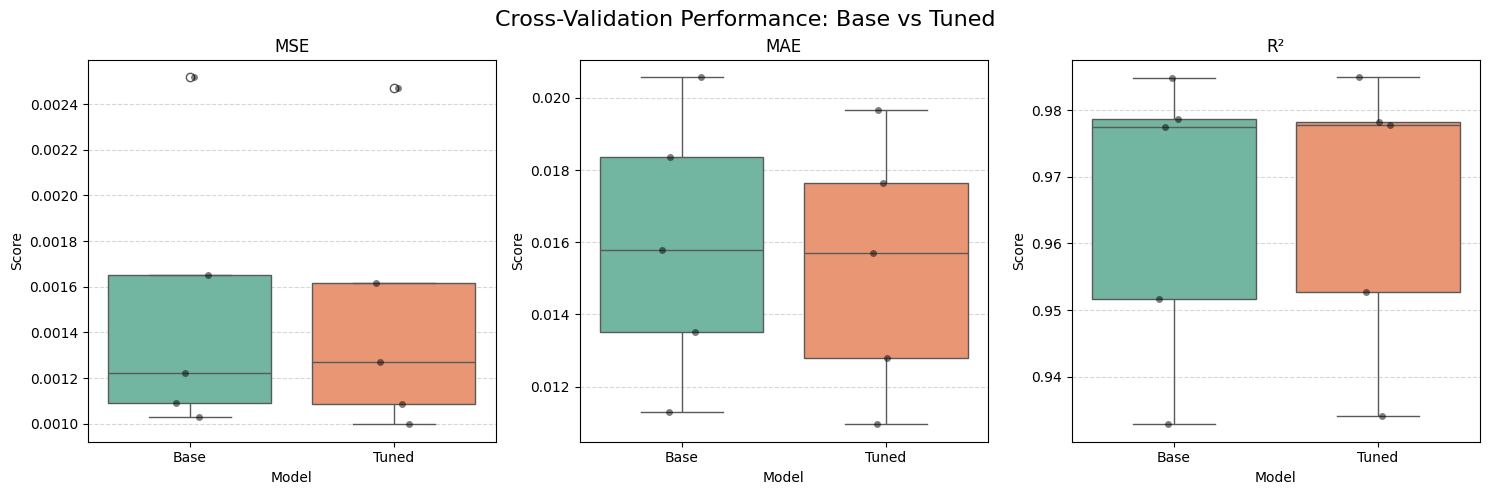

In [11]:
trainer.compare_base_vs_tuned_cv()